# Linking Writing Processes to Writing Quality

## Library

In [1]:
import os
import gc
import random
from glob import glob
from pathlib import Path
from collections import Counter, defaultdict
import re
import copy

import numpy as np
import pandas as pd
import torch
from scipy.stats import skew, kurtosis

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# model
import optuna
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
# /kaggle/working配下にディレクトリを作成
!mkdir models
!mkdir oof

## Configurations

In [3]:
pd.set_option("display.max_columns", 3000)

In [4]:
class Config:
    VERSION = 1
    COMPETITION = "linking-writing-processes-to-writing-quality"
    DATA_PATH = os.path.join("/", "kaggle", "input", COMPETITION)
    OOF_DATA_PATH = Path("./oof")
    MODEL_DATA_PATH = Path("./models")
    
    USES_GPU = False
    
    seed = 42
    
    """
    > Optuna options
    """
    USES_OPTUNA_TUNING = False
    
    test_size_optuna = 0.2
    num_trials_optuna = 80
    num_trials_early_stopping = 40
    
    """
    > Modeling options
    """
    target_col = "score"
    metric = "rmse"
    
    num_boost_rounds = 50500
    early_stopping_round = 250
    verbose = 100
    
    num_folds = 10
    
    if USES_GPU:
        regression_lgb_params["device"] = "gpu"
        regression_xgb_params["tree_method"] = "gpu_hist"
        regression_xgb_params["predictor"] = "gpu_predictor"
        regression_cat_params["task_type"] = "GPU"

### Set seed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # CUDAのseedを発生するためにtorchを使用
    torch.manual_seed(seed)
    if Config.USES_GPU:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(Config.seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


## Load data

In [6]:
train_df = pd.read_csv(os.path.join(Config.DATA_PATH, "train_logs.csv"))
scores_df = pd.read_csv(os.path.join(Config.DATA_PATH, "train_scores.csv"))

test_df = pd.read_csv(os.path.join(Config.DATA_PATH, "test_logs.csv"))

In [7]:
train_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [8]:
scores_df

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


## Feature engineering

### Essay Constructor

- MASKされてバラバラになったエッセイを再構築する！
- https://www.kaggle.com/code/yuriao/fast-essay-constructor

In [9]:
class EssayConstructor:
    def get_essays(self, df):
        # 必要なカラムのみ抽出
        text_input_df = copy.deepcopy(
            df[["id", "activity", "cursor_position", "text_change"]]
        )
        text_input_df = text_input_df[text_input_df.activity != "Nonproduction"] # Nonproductionの除外
        
        tqdm.pandas()
        essay = text_input_df.groupby("id")[
            ["activity", "cursor_position", "text_change"]
        ].progress_apply(lambda v: self._process_inputs(v))
        
        essay_df = essay.to_frame().reset_index()
        essay_df.columns = ["id", "essay"]
        
        return essay_df
        
    def _process_inputs(self, currTextInput):
        """データのテキスト入力イベントの値からエッセイを復元
        
        Args:
            currTextInput: train_logsからinput系のカラムを抽出したもの
                ["activity", "cursor_position", "text_change", "id"]
        """
        # Where the essay content will be stored
        essayText = ""
        
        # Produces the essay
        for Input in currTextInput.values:
            activity = Input[0]
            
            if activity == 'Replace':
                # splits text_change at ' => '
                replaceTxt = Input[2].split(' => ')
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                
            elif activity == 'Paste':
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                
            elif activity == 'Remove/Cut':
                # DONT TOUCH
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                
            elif "M" in activity:
                # Gets rid of the "Move from to" text
                croppedTxt = activity[10:]              
                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(' To ')              
                # Splits split text again by ', ' for each item
                valueArr = [item.split(', ') for item in splitTxt]              
                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        # DONT TOUCH
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            
            else:
                # If activity = input
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
        
        return essayText

### Preprocessor

In [10]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

In [11]:
class Preprocessor:
    def __init__(self, seed):
        """コンストラクタ
        
        Args:
            seed: シード値
        """
        self.seed = seed
        
        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
        ]
        self.text_changes_dict = {
            "q": "q",
            " ": "space",
            "NoChange": "NoChange",
            ".": "full_stop",
            ",": "comma",
            "\n": "newline",
            "'": "single_quote",
            '"': "double_quote",
            "-": "dash",
            "?": "question_mark",
            ";": "semicolon",
            "=": "equals",
            "/": "slash",
            "\\": "double_backslash",
            ":": "colon",
        }
        self.punctuations = ['"', ".", ",", '"', "-", ";", ":", "?", "!", "<", ">", "/", "@", "#", "$", "%", "^", "&", "*", "(", ")", "_", "+"]
        
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 70, 100]
        
        self.idf = defaultdict(float)
        
        self.essay_constructor = EssayConstructor()
    
    def make_feats(self, df: pd.DataFrame):
        """特徴量の作成
        
        Args:
            df (pd.DataFrame): 入力データ
        """
        print("Starting to engineer features")
        
        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})
        # TODO: Argsとする
        essay_df = self.essay_constructor.get_essays(df)
        
        # Essay統計量
        essay_agg_df = self._count_essay_str(essay_df)
        feats = feats.merge(essay_agg_df, on="id", how="left")
        
        word_agg_df = self._calc_word_aggregations(essay_df)
        feats = feats.merge(word_agg_df, on="id", how="left")
        
        sentence_agg_df = self._calc_sentence_aggregations(essay_df)
        feats = feats.merge(sentence_agg_df, on="id", how="left")
        
        paragraph_agg_df = self._calc_paragraph_aggregations(essay_df)
        feats = feats.merge(paragraph_agg_df, on="id", how="left")
        
        # 統計量
        tmp_df = self._count_activity(df=df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
#         tmp_df = self._count_event(df=df, colname="down_event")
#         feats = pd.concat([feats, tmp_df], axis=1)
        
#         tmp_df = self._count_event(df=df, colname="up_event")
#         feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self._count_text_change(df=df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
#         tmp_df = self._count_punctuations(df=df, colname="down_event")
#         feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self._calc_p_bursts(df=df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")
        
        tmp_df = self._calc_r_bursts(df=df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")
        
        # space features
        tmp_df = self._create_space_features(df)
        feats = feats.merge(tmp_df, on="id", how="left")
        
        # shifted features
        # 特定の時間や行動間のギャップを計算
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
            
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)
        
        # cursor position shift
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")["cursor_position"].shift(gap)
            df[f"cursor_position_change{gap}"] = df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            df[f"cursor_position_abs_change{gap}"] = np.abs(df[f"cursor_position_change{gap}"])
        
        df.drop(columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True)
        
        # word count shift
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = df["word_count"] - df[f"word_count_shift{gap}"]
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
            
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)
        
        # get aggregate statistical features
        # [(特徴量の名前, [追加したい統計量])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["first", "last", "max", "mean", "std"]),
            ("down_time", ["first", "last", "max", "mean", "std"]),
            ("action_time", ["sum", "max", "mean", "std", "sem", skew, kurtosis]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "mean", "std"]),
            ("word_count", ["nunique", "max", "mean", "std"]),
        ]
    
        for gap in self.gaps:
            feats_stat.extend([
                (f"action_time_gap{gap}", ["first", "last", "max", "min", "mean", "std", "sum"]),
                (f"cursor_position_change{gap}", ["last", "max", "mean", "std", "sum"]),
                (f"word_count_change{gap}", ["mean", "std", "sum"]),
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                
                pbar.set_postfix(column=colname, method=method_name)
                grouped_df = df.groupby(["id"]).agg({colname: method}).reset_index().rename(
                    columns={colname: f"{colname}_{method_name}"}
                )
                feats = feats.merge(grouped_df, on="id", how="left")
        
        # input words
        tmp_df = self._calc_input_word_aggregations(df=df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")
        
        # compare feats
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]
        
        return feats
    
    def _count_essay_str(self, essay_df: pd.DataFrame) -> pd.DataFrame:
        """エッセイの文字数をカウント
        
        Args:
            essay_df (pd.DataFrame): 再構築したEssayデータ
        Returns:
            pd.DataFrame: (id, essay_len)のデータ
        """
        cols_to_drop = ["essay"]
        # Total essay length
        essay_df["essay_len"] = essay_df["essay"].apply(lambda v: len(v))
        essay_df = essay_df.drop(columns=cols_to_drop)
        
        return essay_df
    
    def _calc_word_aggregations(self, essay_df: pd.DataFrame) -> pd.DataFrame:
        """単語ごとに様々な統計量を計算
        
        Args:
            essay_df (pd.DataFrame): 再構築したEssayデータ
        Returns:
            pd.DataFrame: 単語ごとの統計量データ
        """
        word_df = self._split_essays_into_words(essay_df)
        
        word_agg_df = word_df[["id", "word_len"]].groupby(["id"]).agg([
            "mean",
            "std",
            "max",
            "first",
            "last",
            "sem",
            q1,
            "median",
            q3,
            "skew",
            pd.DataFrame.kurt,
            "sum",
        ])
        word_agg_df.columns = ["_".join(v) for v in word_agg_df.columns]
        word_agg_df["id"] = word_agg_df.index
        
        # 長さが以下のリスト内の要素を超える単語数の計算
        for v in [5, 6, 7, 8, 9, 10, 11, 12]:
            word_agg_df[f"word_len_ge_{v}_count"] = (
                word_df[word_df["word_len"] >= v].groupby(["id"]).count().iloc[:, 0]
            )
            word_agg_df[f"word_len_ge_{v}_count"] = word_agg_df[f"word_len_ge_{v}_count"].fillna(0)
            
        word_agg_df = word_agg_df.reset_index(drop=True)

        return word_agg_df
    
    def _split_essays_into_words(self, essay_df: pd.DataFrame) -> pd.DataFrame:
        """再構築したEssayを単語単位で分割
        
        Args:
            essay_df (pd.DataFrame): 再構築したEssayデータ
        Returns:
            pd.DataFrame: 単語単位に分割したEssayデータ
        """
        # 単語単位でsplitしたそれぞれをexplodeで連結
        essay_df["word"] = essay_df["essay"].apply(
            lambda v: re.split(" |\\n|\\n\\n|\\.|\\?|\\!", v)
        )
        essay_df = essay_df.explode("word")
        
        # 単語長(num of characters in word)
        essay_df["word_len"] = essay_df["word"].apply(lambda v: len(v))
        essay_df = essay_df[essay_df["word_len"] != 0]
        
        return essay_df
    
    def _calc_sentence_aggregations(self, essay_df: pd.DataFrame) -> pd.DataFrame:
        """文章ごとに様々な統計量を計算
        
        Args:
            essay_df (pd.DataFrame): 再構築したEssayデータ
        Returns:
            pd.DataFrame: 文章ごとの統計量データ
        """
        sentence_df = self._split_essays_into_sentences(essay_df)
        
        sentence_agg_df = sentence_df[
            ["id", "sentence_len", "sentence_word_count"]
        ].groupby(["id"]).agg([
            "mean",
            "std",
            "min",
            "max",
            "first",
            "last",
            "sem",
            q1,
            "median",
            q3,
            "skew",
            pd.DataFrame.kurt,
            "sum",
        ])
        
        sentence_agg_df.columns = ["_".join(v) for v in sentence_agg_df.columns]
        sentence_agg_df["id"] = sentence_agg_df.index
        
        # 長さが以下のリスト内の要素を超える文章数の計算
        for v in [50, 60, 75, 100]:
            sentence_agg_df[f"sentence_len_ge_{v}_count"] = (
                sentence_df[sentence_df["sentence_len"] >= v].groupby(["id"]).count().iloc[:, 0]
            )
            sentence_agg_df[f"sentence_len_ge_{v}_count"] = (
                sentence_agg_df[f"sentence_len_ge_{v}_count"].fillna(0)
            )
            
        sentence_agg_df = sentence_agg_df.reset_index(drop=True)
        
        return sentence_agg_df
    
    def _split_essays_into_sentences(self, essay_df: pd.DataFrame) -> pd.DataFrame:
        """再構築したEssayを文章単位で分割
        
        Args:
            essay_df (pd.DataFrame): 再構築したEssayデータ
        Returns:
            pd.DataFrame: 文章単位で分割したEssayデータ
        """
        # 文章単位でsplitしたそれぞれをexplodeで連結
        essay_df["sentence"] = essay_df["essay"].apply(
            lambda v: re.split("\\.|\\?|\\!", v)
        )
        essay_df = essay_df.explode("sentence")
        
        essay_df["sentence"] = essay_df["sentence"].apply(lambda v: v.replace("\n\n", "\n").replace("\n", "").strip())
        
        # 文章内の文字数
        essay_df["sentence_len"] = essay_df["sentence"].apply(lambda v: len(v))
        # 文章内の単語数
        essay_df["sentence_word_count"] = essay_df["sentence"].apply(lambda v: len(v.split(" ")))
        
        essay_df = essay_df[essay_df.sentence_len != 0].reset_index(drop=True)
        
        return essay_df
    
    def _calc_paragraph_aggregations(self, essay_df: pd.DataFrame) -> pd.DataFrame:
        """段落ごとに様々な統計量を計算
        
        Args:
            essay_df (pd.DataFrame): 再構築したEssayデータ
        Returns:
            pd.DataFrame: 段落ごとの統計量データ
        """
        paragraph_df = self._split_essays_into_paragraphs(essay_df)
        
        paragraph_agg_df = paragraph_df[
            ["id", "paragraph_len", "paragraph_word_count"]
        ].groupby("id").agg([
            "mean",
            "std",
            "min",
            "max",
            "first",
            "last",
            "sem",
            q1,
            "median",
            q3,
            "skew",
            pd.DataFrame.kurt,
            "sum",
        ])
        
        paragraph_agg_df.columns = ["_".join(v) for v in paragraph_agg_df.columns]
        paragraph_agg_df["id"] = paragraph_agg_df.index
        paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
        
        return paragraph_agg_df
 
    def _split_essays_into_paragraphs(self, essay_df: pd.DataFrame) -> pd.DataFrame:
        """再構築したEssayを段落単位で分割
        
        Args:
            essay_df (pd.DataFrame): 再構築したEssayデータ
        Returns:
            pd.DataFrame: 段落単位で分割したEssayデータ
        """
        # 段落単位でsplitしたそれぞれをexplodeで連結
        essay_df["paragraph"] = essay_df["essay"].apply(
            lambda v: v.replace("\n\n", "\n").split("\n")
        )
        essay_df = essay_df.explode("paragraph")
        
        # 段落内の文字数
        essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda v: len(v))
        # 段落内の文章数
#         essay_df["paragraph_sentence_count"] = essay_df["paragraph"].apply(lambda v: len(v.split("\\.|\\?|\\!")))
        # 段落内の単語数
        essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(lambda v: len(v.split(' ')))
        
        essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)
        
        return essay_df
    
    def _count_activity(self, df: pd.DataFrame) -> pd.DataFrame:
        """activityカラムのカウント
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: activityカラムを(tfidf|通常)でカウントしたデータ
        """
        grouped_df = df.groupby("id").agg({"activity": list}).reset_index()
        
        l = []
        for cols in tqdm(grouped_df["activity"].values):
            counter = list(Counter(cols).items())
            
            # 初期化
            d = {}
            for v in self.activities:
                d[v] = 0
                
            # "move from X to Y"も考慮する
            d["move_to"] = 0
            
            for v in counter:
                item, count = v[0], v[1]
                if item in d:
                    d[item] = count
                else:
                    d["move_to"] += count
                    
            l.append(d)
            
        count_df = pd.DataFrame(l)
        tfidf_df, normal_df = pd.DataFrame(l), pd.DataFrame(l)
        
        tfidf_cols = [f"activity_{v}_tfidf_count" for v in count_df.columns]
        normal_cols = [f"activity_{v}_normal_count" for v in count_df.columns]
        
        tfidf_df.columns = tfidf_cols
        normal_df.columns = normal_cols
        
        counts = tfidf_df.sum(1)
        for col in tfidf_cols:
            if col in self.idf.keys():
                idf =self.idf[col]
            else:
                idf = df.shape[0] / (tfidf_df[col].sum()+1)
                idf = np.log(idf)
                self.idf[col] = idf
                
            tfidf_df[col] = 1+np.log(tfidf_df[col] / counts)
            tfidf_df[col] *= idf
            
        agg_df = pd.concat([tfidf_df, normal_df], axis=1)
        
        return agg_df
    
    def _count_event(self, df: pd.DataFrame, colname: str) -> pd.DataFrame:
        """(down_event|up_event)カラムのカウント
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: (down_event|up_event)カラムを(tfidf|通常)でカウントしたデータ
        """
        grouped_df = df.groupby("id").agg({colname: list}).reset_index()
        
        l = []
        for cols in tqdm(grouped_df[colname].values):
            counter = list(Counter(cols).items())
            
            # 初期化
            d = {}
            for v in self.activities:
                d[v] = 0
                
            # "move from X to Y"も考慮する
            d["move_to"] = 0
            
            for v in counter:
                item, count = v[0], v[1]
                if item in d:
                    d[item] = count
                    
            l.append(d)
            
        count_df = pd.DataFrame(l)
        tfidf_df, normal_df = pd.DataFrame(l), pd.DataFrame(l)
        
        tfidf_cols = [f"{colname}_{v}_tfidf_count" for v in count_df.columns]
        normal_cols = [f"{colname}_{v}_normal_count" for v in count_df.columns]
        
        tfidf_df.columns = tfidf_cols
        normal_df.columns = normal_cols
        
        counts = tfidf_df.sum(1)
        for col in tfidf_cols:
            if col in self.idf.keys():
                idf =self.idf[col]
            else:
                idf = df.shape[0] / (tfidf_df[col].sum()+1)
                idf = np.log(idf)
                self.idf[col] = idf
                
            tfidf_df[col] = 1+np.log(tfidf_df[col] / counts)
            tfidf_df[col] *= idf
            
        agg_df = pd.concat([tfidf_df, normal_df], axis=1)
        
        return agg_df
    
    def _count_text_change(self, df: pd.DataFrame) -> pd.DataFrame:
        """text_changeカラムのカウント
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: text_changeカラムを(tfidf|通常)でカウントしたデータ
        """
        grouped_df = df.groupby("id").agg({"text_change": list}).reset_index()

        l = []
        for cols in tqdm(grouped_df["text_change"].values):
            counter = list(Counter(cols).items())
            
            # 初期化
            d = {}
            for k in self.text_changes_dict.keys():
                d[k] = 0
                
            for v in counter:
                item, count = v[0], v[1]
                if item in d:
                    d[item] = count
                    
            l.append(d)
            
        count_df = pd.DataFrame(l)
        tfidf_df, normal_df = pd.DataFrame(l), pd.DataFrame(l)
        
        tfidf_cols = [f"text_change_{self.text_changes_dict[v]}_tfidf_count" for v in count_df.columns]
        normal_cols = [f"text_change_{self.text_changes_dict[v]}_normal_count" for v in count_df.columns]
        
        tfidf_df.columns = tfidf_cols
        normal_df.columns = normal_cols
        
        counts = tfidf_df.sum(1)
        for col in tfidf_cols:
            if col in self.idf.keys():
                idf =self.idf[col]
            else:
                idf = df.shape[0] / (tfidf_df[col].sum()+1)
                idf = np.log(idf)
                self.idf[col] = idf
                
            tfidf_df[col] = 1+np.log(tfidf_df[col] / counts)
            tfidf_df[col] *= idf
            
        agg_df = pd.concat([tfidf_df, normal_df], axis=1)
        
        return agg_df
    
    def _count_punctuations(self, df: pd.DataFrame, colname: str) -> pd.DataFrame:
        """句読点の数をカウント
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: 句読点の数をカウントしたデータ
        """
        grouped_df = df.groupby("id").agg({colname: list}).reset_index()
            
        l = []
        for cols in tqdm(grouped_df[colname].values):
            c = 0
            counter = list(Counter(cols).items())
            for v in counter:
                item, count = v[0], v[1]
                if item in self.punctuations:
                    c += count
            l.append(c)
            
        count_df = pd.DataFrame({"punct_count": l})
        
        return count_df
    
    def _calc_p_bursts(self, df: pd.DataFrame) -> pd.DataFrame:
        """P-burstの計算
        一時停止するまでに書かれたもの = バーッと書いた際の行動？
        今回は2秒未満という条件にしている
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: P-burstの様々な統計量を含めたデータ
        """
        # up_timeを1行ずらして新しい列として追加
        df["up_time_lagged"] = df.groupby("id")["up_time"].shift(1).fillna(df["down_time"])

        # down_timeとup_time_laggedの差の絶対値を秒単位で計算し、新しい列として追加
        df["time_diff"] = abs(df["down_time"] - df["up_time_lagged"]) / 1000

        # 特定のactivityを持つ行をフィルタリング
        tmp_df = df[df["activity"].isin(["Input", "Remove/Cut"])].copy()

        # time_diffが2秒未満の場合にTrueを設定
        tmp_df["time_diff_lt_2"] = tmp_df["time_diff"] < 2

        # time_diff_lt_2がTrueの連続するグループごとにカウント
        tmp_df["P-bursts"] = tmp_df.groupby("id")["time_diff_lt_2"].transform(
            lambda x: x.cumsum() - x.cumsum().where(~x).ffill().fillna(0)
        )

        tmp_df = tmp_df.dropna(subset=["P-bursts"])
        
        # idごとに集計
        output_df = tmp_df.groupby("id").agg({"P-bursts": [
            "mean",
            "std",
            "max",
            "last",
            "sem",
            q1,
            "median",
            q3,
            "skew",
            pd.DataFrame.kurt,
            "sum",
        ]})

        # 列名の整形
        output_df.columns = ["_".join(col).strip() for col in output_df.columns.values]
        
        return output_df
    
    def _calc_r_bursts(self, df: pd.DataFrame) -> pd.DataFrame:
        """R-burstの計算
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: R-burstの様々な統計量を含めたデータ
        """
        # 'Input', 'Remove/Cut'のactivityを持つ行をフィルタリング
        tmp_df = df[df["activity"].isin(["Input", "Remove/Cut"])].copy()

        # 'Remove/Cut'のactivityを持つ行にTrueを設定
        tmp_df["activity_remove_cut"] = tmp_df["activity"] == "Remove/Cut"

        # activity_remove_cutがTrueの連続するグループごとにカウント
        tmp_df["R-bursts"] = tmp_df.groupby("id")["activity_remove_cut"].transform(
            lambda x: x.cumsum() - x.cumsum().where(~x).ffill().fillna(0)
        )

        tmp_df = tmp_df.dropna(subset=["R-bursts"])

        # idごとに集計
        output_df = tmp_df.groupby("id").agg({"R-bursts": [
            "mean",
            "std",
            "max",
            "sem",
            "skew",
            pd.DataFrame.kurt,
            "sum",
        ]})

        # 列名の整形
        output_df.columns = ["_".join(col).strip() for col in output_df.columns.values]

        return output_df
    
    def _create_space_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """空白に関する特徴量を生成
        @ref: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs/notebook
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: 空白に関する特徴量データ
        """
        df["up_time_lagged"] = df.groupby("id")["up_time"].shift(1).fillna(df["down_time"])
        df["time_diff"] = abs(df["down_time"] - df["up_time_lagged"]) / 1000
        
        grouped_df = df.groupby("id")["time_diff"]
        largest_latency = grouped_df.max()
        median_latency = grouped_df.median()
        
        initial_pause = df.groupby("id")["down_time"].first() / 1000
        
        pause_half_sec = grouped_df.apply(lambda v: ((v >= 0.5)&(v < 1)).sum())
        pause_1_sec = grouped_df.apply(lambda v: ((v >= 1)&(v < 1.5)).sum())
        pause_1_half_sec = grouped_df.apply(lambda v: ((v >= 1.5)&(v < 2)).sum())
        pause_2_sec = grouped_df.apply(lambda v: ((v >= 2)&(v < 3)).sum())
        pause_3_sec = grouped_df.apply(lambda v: ((v >= 3).sum()))
        
        output_df = pd.DataFrame({
            "id": df["id"].unique(),
            "largest_latency": largest_latency,
            "median_latency": median_latency,
            "initial_pause": initial_pause,
            "pause_half_sec": pause_half_sec,
            "pause_1_sec": pause_1_sec,
            "pause_1_half_sec": pause_1_half_sec,
            "pause_2_sec": pause_2_sec,
            "pause_3_sec": pause_3_sec,
        }).reset_index(drop=True)
        
        return output_df
        
    def _calc_input_word_aggregations(self, df: pd.DataFrame) -> pd.DataFrame:
        """text_changeイベントで入力された単語の統計量を計算
        
        Args:
            df (pd.DataFrame): 入力データ
        Returns:
            pd.DataFrame: 入力された単語の統計量データ
        """
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        
        grouped_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        
        # 整形
        grouped_df["text_change"] = grouped_df["text_change"].apply(lambda x: "".join(x))
        grouped_df["text_change"] = grouped_df["text_change"].apply(lambda x: re.findall(r"q+", x))
        
        # 統計量の算出
        grouped_df["input_word_count"] = grouped_df["text_change"].apply(len)
        grouped_df["input_word_len_mean"] = grouped_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        grouped_df["input_word_len_max"] = grouped_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        grouped_df["input_word_len_std"] = grouped_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        
        grouped_df.drop(["text_change"], axis=1, inplace=True)
        
        return grouped_df

In [12]:
preprocessor = Preprocessor(seed=Config.seed)

processed_train_df = preprocessor.make_feats(train_df)
processed_test_df = preprocessor.make_feats(test_df)

Starting to engineer features


  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/2471 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100


  0%|          | 0/37 [00:00<?, ?it/s]

Starting to engineer features


/tmp/ipykernel_20/1032863483.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
/tmp/ipykernel_20/1032863483.py:177: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
/tmp/ipykernel_20/1032863483.py:178: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/37 [00:00<?, ?it/s]

/tmp/ipykernel_20/1032863483.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
/tmp/ipykernel_20/1032863483.py:177: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
/tmp/ipykernel_20/1032863483.py:178: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [13]:
processed_train_df = processed_train_df.merge(scores_df, on="id", how="left")

In [14]:
processed_train_df.head()

,id,essay_len,word_len_mean,word_len_std,word_len_max,word_len_first,word_len_last,word_len_sem,word_len_q1,word_len_median,word_len_q3,word_len_skew,word_len_kurt,word_len_sum,word_len_ge_5_count,word_len_ge_6_count,word_len_ge_7_count,word_len_ge_8_count,word_len_ge_9_count,word_len_ge_10_count,word_len_ge_11_count,word_len_ge_12_count,sentence_len_mean,sentence_len_std,sentence_len_min,sentence_len_max,sentence_len_first,sentence_len_last,sentence_len_sem,sentence_len_q1,sentence_len_median,sentence_len_q3,sentence_len_skew,sentence_len_kurt,sentence_len_sum,sentence_word_count_mean,sentence_word_count_std,sentence_word_count_min,sentence_word_count_max,sentence_word_count_first,sentence_word_count_last,sentence_word_count_sem,sentence_word_count_q1,sentence_word_count_median,sentence_word_count_q3,sentence_word_count_skew,sentence_word_count_kurt,sentence_word_count_sum,sentence_len_ge_50_count,sentence_len_ge_60_count,sentence_len_ge_75_count,sentence_len_ge_100_count,paragraph_len_mean,paragraph_len_std,paragraph_len_min,paragraph_len_max,paragraph_len_first,paragraph_len_last,paragraph_len_sem,paragraph_len_q1,paragraph_len_median,paragraph_len_q3,paragraph_len_skew,paragraph_len_kurt,paragraph_len_sum,paragraph_word_count_mean,paragraph_word_count_std,paragraph_word_count_min,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum,activity_Input_tfidf_count,activity_Remove/Cut_tfidf_count,activity_Nonproduction_tfidf_count,activity_Replace_tfidf_count,activity_Paste_tfidf_count,activity_move_to_tfidf_count,activity_Input_normal_count,activity_Remove/Cut_normal_count,activity_Nonproduction_normal_count,activity_Replace_normal_count,activity_Paste_normal_count,activity_move_to_normal_count,text_change_q_tfidf_count,text_change_space_tfidf_count,text_change_NoChange_tfidf_count,text_change_full_stop_tfidf_count,text_change_comma_tfidf_count,text_change_newline_tfidf_count,text_change_single_quote_tfidf_count,text_change_double_quote_tfidf_count,text_change_dash_tfidf_count,text_change_question_mark_tfidf_count,text_change_semicolon_tfidf_count,text_change_equals_tfidf_count,text_change_slash_tfidf_count,text_change_double_backslash_tfidf_count,text_change_colon_tfidf_count,text_change_q_normal_count,text_change_space_normal_count,text_change_NoChange_normal_count,text_change_full_stop_normal_count,text_change_comma_normal_count,text_change_newline_normal_count,text_change_single_quote_normal_count,text_change_double_quote_normal_count,text_change_dash_normal_count,text_change_question_mark_normal_count,text_change_semicolon_normal_count,text_change_equals_normal_count,text_change_slash_normal_count,text_change_double_backslash_normal_count,text_change_colon_normal_count,P-bursts_mean,P-bursts_std,P-bursts_max,P-bursts_last,P-bursts_sem,P-bursts_q1,P-bursts_median,P-bursts_q3,P-bursts_skew,P-bursts_kurt,P-bursts_sum,R-bursts_mean,R-bursts_std,R-bursts_max,R-bursts_sem,R-bursts_skew,R-bursts_kurt,R-bursts_sum,largest_latency,median_latency,initial_pause,pause_half_sec,pause_1_sec,pause_1_half_sec,pause_2_sec,pause_3_sec,event_id_max,up_time_first,up_time_last,up_time_max,up_time_mean,up_time_std,down_time_first,down_time_last,down_time_max,down_time_mean,down_time_std,action_time_sum,action_time_max,action_time_mean,action_time_std,action_time_sem,action_time_skew,action_time_kurtosis,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,cursor_position_std,word_count_nunique,word_count_max,word_count_mean,word_count_std,action_time_gap1_first,action_time_gap1_last,action_time_gap1_max,action_time_gap1_min,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_sum,cursor_position_change1_last,cursor_position_change1_max,cursor_position_chan

## Check correlation coefficients

In [15]:
processed_train_df.drop(["id"], axis=1).corr().sort_values(["score"])["score"]

action_time_gap5_mean      -0.606004
action_time_gap10_mean     -0.602954
action_time_gap3_mean      -0.600881
action_time_gap20_mean     -0.596831
action_time_gap50_mean     -0.585539
                              ...   
sentence_len_ge_75_count    0.682049
word_len_ge_5_count         0.686487
word_len_ge_7_count         0.693650
word_len_ge_6_count         0.697498
score                       1.000000
Name: score, Length: 319, dtype: float64

## Split train data into folds for cross-validation

In [16]:
kfold = KFold(n_splits=Config.num_folds, shuffle=True, random_state=Config.seed)

for fold, (_, val_idx) in enumerate(kfold.split(processed_train_df)):
    processed_train_df.loc[val_idx, "fold"] = fold

/tmp/ipykernel_20/749667847.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_train_df.loc[val_idx, "fold"] = fold


In [17]:
# save
processed_train_df.to_csv("processed_train.csv", index=False)

## Optimize Hyperparameters with Optuna

In [18]:
X = processed_train_df.drop(columns=["id", "fold", Config.target_col])
Y = processed_train_df[Config.target_col]

In [19]:
def objective(trial, data=X, target=Y):
    X_train, X_val, y_train, y_val = train_test_split(
        data,
        target,
        test_size=Config.test_size_optuna,
        random_state=Config.seed,
    )
    
    param = {
        'metric': Config.metric, 
        'random_state': Config.seed,
        'n_estimators': Config.num_boost_rounds // 100,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'num_leaves' : trial.suggest_int('num_leaves', 8, 64),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }
    
    model = lgb.LGBMRegressor(**param)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=Config.early_stopping_round,
        verbose=False,
    )
    
    preds = model.predict(X_val)
    
    rmse = mean_squared_error(y_val, preds, squared=False)
    
    return rmse

In [20]:
if Config.USES_OPTUNA_TUNING:
    study = optuna.create_study(direction="minimize", study_name="Optimize boosting hyperparameters")
    study.optimize(objective, n_trials=Config.num_trials_optuna)
    
    print('Best trial:', study.best_trial.params)

## Training

In [21]:
feature_names = list(
    filter(
        lambda x: x not in [Config.target_col, "id", "fold"], processed_train_df.columns
    )
)

if Config.USES_OPTUNA_TUNING:
    best_params = study.best_params
else:
    best_params = {'reg_alpha': 0.02408301883205052, 'reg_lambda': 0.0100504047966344, 'colsample_bytree': 0.8801038008695974, 'subsample': 0.5252452517239059, 'learning_rate': 0.06504644086287203, 'num_leaves': 8, 'min_child_samples': 73}
    
lgbm_params = {
    "metric": Config.metric,
    "random_state": Config.seed,
    "n_estimators": Config.num_boost_rounds // 100,
    **best_params,
}

# [fold]: model
models_d = {}

for fold in range(Config.num_folds):
    print(f"Training for Fold {fold}")
    
    X_train = processed_train_df[processed_train_df["fold"] != fold][feature_names]
    y_train = processed_train_df[processed_train_df["fold"] != fold][Config.target_col]
    
    X_val = processed_train_df[processed_train_df["fold"] == fold][feature_names]
    y_val = processed_train_df[processed_train_df["fold"] == fold][Config.target_col]
    
    model = lgb.LGBMRegressor(**lgbm_params)
    
    model.fit(
        X_train,
        y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=-1,
        eval_metric=Config.metric,
        early_stopping_rounds=Config.early_stopping_round,
    )
    
    # save
    models_d[fold] = model

Training for Fold 0


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 1


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 2


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 3


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 4


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 5


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 6


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 7


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 8


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 9


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


## Mean feature importance of LGBM models

In [22]:
feature_importance_values = np.asarray(
    [model.feature_importances_ for model in models_d.values()]
).mean(axis=0)

feature_importance_df = pd.DataFrame({
    "name": feature_names,
    "importance": feature_importance_values,
})

feature_importance_df = feature_importance_df.sort_values(
    "importance",
    ascending=False,
).head(50)

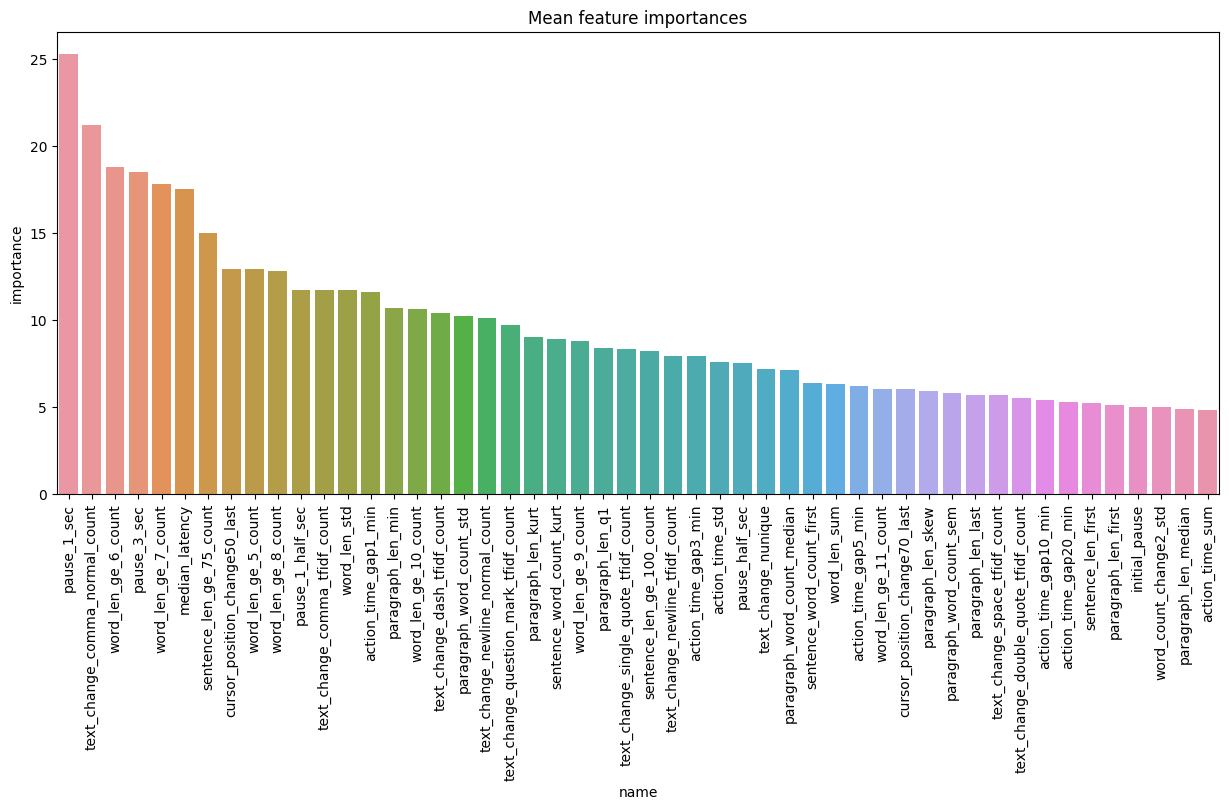

In [23]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(
    data=feature_importance_df,
    x="name",
    y="importance",
)
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

## Evaluation of OOF preds on trianing set (CV)

In [24]:
# TODO: 学習時に一緒に計算する
# scores(list)にいれればできそう
for fold in range(Config.num_folds):
    print(f"Predicting the train set with fold{fold}")
    X_train = processed_train_df[processed_train_df["fold"] != fold][feature_names]
    y_train = processed_train_df[processed_train_df["fold"] != fold][Config.target_col]
    
    X_val = processed_train_df[processed_train_df["fold"] == fold][feature_names]
    y_val = processed_train_df[processed_train_df["fold"] == fold][Config.target_col]
    
    model = models_d[fold]
    pred = model.predict(
        X_val,
        num_iteration=model.best_iteration_,
    )
    
    processed_train_df.loc[X_val.index, f"pred_{Config.target_col}"] = pred

Predicting the train set with fold0
Predicting the train set with fold1
Predicting the train set with fold2


/tmp/ipykernel_20/2605761640.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_train_df.loc[X_val.index, f"pred_{Config.target_col}"] = pred


Predicting the train set with fold3
Predicting the train set with fold4
Predicting the train set with fold5
Predicting the train set with fold6
Predicting the train set with fold7
Predicting the train set with fold8
Predicting the train set with fold9


In [25]:
rmse = mean_squared_error(
    processed_train_df[Config.target_col],
    np.clip(
        processed_train_df[f"pred_{Config.target_col}"],
        a_min=0.5,
        a_max=6.0,
    ),
    squared=False,         
)

print("CV RMSE: ", rmse)

CV RMSE:  0.6126905366624545


## Make submission

In [26]:
for fold in range(Config.num_folds):
    print(f"Predict the test set with fold{fold}")
    X_test = processed_test_df[feature_names]
    
    model = models_d[fold]
    pred = model.predict(
        X_test,
        num_iteration=model.best_iteration_,
    )
    print(pred)
    
    processed_test_df[f"pred_{Config.target_col}_fold{fold}"] = pred
    
processed_test_df[Config.target_col] = processed_test_df[
    [f"pred_{Config.target_col}_fold{fold}" for fold in range(Config.num_folds)]
].mean(axis=1)

processed_test_df[Config.target_col] = np.clip(
    processed_test_df[Config.target_col],
    a_min=0.5,
    a_max=6.0,
)

Predict the test set with fold0
[1.51435654 1.43614505 1.4524202 ]
Predict the test set with fold1
[1.50785462 1.38302993 1.41621996]
Predict the test set with fold2
[1.59985591 1.53297952 1.50987416]
Predict the test set with fold3
[1.41387522 1.27152124 1.33449045]
Predict the test set with fold4
[1.43103435 1.45047893 1.45047893]
Predict the test set with fold5
[1.57647418 1.53161274 1.53161274]
Predict the test set with fold6
[1.5187648  1.45184269 1.45184269]
Predict the test set with fold7
[1.70866094 1.65707732 1.61664751]
Predict the test set with fold8
[1.5368977  1.57426853 1.58623782]
Predict the test set with fold9
[1.43281572 1.44790544 1.43590699]


/tmp/ipykernel_20/2519098899.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_test_df[f"pred_{Config.target_col}_fold{fold}"] = pred
/tmp/ipykernel_20/2519098899.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_test_df[f"pred_{Config.target_col}_fold{fold}"] = pred
/tmp/ipykernel_20/2519098899.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [27]:
submission_df = processed_test_df[["id", Config.target_col]]
submission_df

,id,score
0,0000aaaa,1.524059
1,2222bbbb,1.473686
2,4444cccc,1.478573


In [28]:
submission_df.to_csv('submission.csv', index=False)

## Reference

- https://www.kaggle.com/code/takaito/lwpwq-public-baseline-notebook
    - v1(0.659)
- https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline
    - v2()